In [1]:
import pandas as pd
import numpy as np
import datetime as dt
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
import pickle
import matplotlib.pyplot as plt
import googlemaps
import re
import warnings

warnings.filterwarnings('ignore')

In [2]:


#Read data
df = pd.read_csv('final_data_riyadh.csv')

In [3]:
df

,المدينة,الحي,تاريخ الصفقة(هـ),المساحة (متر مربع),سعر المتر المربع (ريال),التصنيف,النوع
0,الرياض,حي/أحد,2009/01/21,625.00,261,سكني,قطعة أرض
1,الرياض,حي/أحد,2009/01/26,435.00,103,سكني,قطعة أرض
2,الرياض,حي/أحد,2009/01/20,625.00,75,سكني,قطعة أرض
3,الرياض,حي/أحد,2009/01/25,500.00,170,سكني,قطعة أرض
4,الرياض,حي/أحد,2009/01/03,993.05,161,سكني,قطعة أرض
...,...,...,...,...,...,...,...
952502,شقراء,حي/أخرى,2020/08/10,600.00,2333,تجاري,شقة
952503,عرقه,حي/عرقه,2020/08/19,142.13,2814,تجاري,شقة
952504,الدوادمي,حي/أخرى,2020/08/11,28.08,2671,تجاري,معرض/محل
952505,حوطة بني تميم,حي/الوسيطى بأسفل الباطن,2020/08/17,197.00,457,تجاري,بيت


In [4]:
#change coolumns name to english
df = df.rename(columns={'التصنيف':'category'})
df = df.rename(columns={'المدينة':'city'})
df = df.rename(columns={'النوع':'type'})
df = df.rename(columns={'سعر المتر المربع (ريال)':'price_per_sq'})
df = df.rename(columns={'المساحة (متر مربع)':'size'})
df = df.rename(columns={'تاريخ الصفقة(هـ)':'sold_date'})
df = df.rename(columns={'الحي':'area_ar'})

#change sold date type to datatime
df['sold_date'] = pd.to_datetime(df['sold_date'])
df['year'] = df['sold_date'].apply(lambda x :x.year)



#remove all types that not a land
df = df[df['type'].isin(['قطعة أرض'])]  
df = df[df['city'].isin(['الرياض'])]  




#remove type and city since we only have one type and city
#remove type since we only have one type
df = df.drop('type',axis=1)
df = df.drop('city',axis=1)

#remove size 
df = df.drop('size',axis=1)


#map any area that occurs less than 20 times to other
value_counts = df.area_ar.value_counts() 
to_remove = value_counts[value_counts <= 20].index
df.replace(to_remove, "حي/أخرى", inplace=True)
df.area_ar.value_counts()

#remove all column that is in 'حي/أخرى'
df = df.drop(df[df.area_ar.str.contains('حي/أخرى')].index)



In [5]:
{column: len(df[column].unique()) for column in df.columns}

{'area_ar': 180,
 'sold_date': 2893,
 'price_per_sq': 9767,
 'category': 2,
 'year': 13}

In [7]:
# Find the mean for the outliars

areas = df.area_ar.unique()
years = df.year.unique()

result = df[0:0]
for area in areas:
    for year in years:
        x = df[0:0]
        x = df.loc[(df['area_ar'] == area) & (df['year']==year)]
        if not x.empty:
            lower_limit = x['price_per_sq'].quantile(0.25)
            upper_limit = x['price_per_sq'].quantile(0.75)
            x['price_per_sq'] = x['price_per_sq'].apply(lambda x : np.NaN if (x > upper_limit or x < lower_limit) else x)
            mean = x.price_per_sq.mean()
            x.price_per_sq.fillna(value= mean,inplace=True)   
            result = result.append(x)

In [8]:
df2 = result.copy()

In [9]:
(df2.isnull()).sum()

area_ar           0
sold_date         0
price_per_sq    138
category          0
year              0
dtype: int64

In [10]:
df2 = df2[df2['price_per_sq'].notna()]

In [11]:
(df2.isnull()).sum()

area_ar         0
sold_date       0
price_per_sq    0
category        0
year            0
dtype: int64

In [12]:
df2 = df2.drop('year',axis=1)

In [13]:
df2['category'] = df2['category'].replace({"سكني":"Residential","تجاري":"Commercial"})


In [14]:

#Enter your google maps api key
gmapsApiKey=""
gmaps = googlemaps.Client(key=gmapsApiKey)
unique_areas=df2.area_ar.unique()

df2['area_en'] = df2['area_ar']

for area in unique_areas:
    r1 = re.match(r"حي\/",area)
    if r1!=None:
        area1 =  "Riyadh " + area 
        geocode_result = gmaps.geocode(area1)
        if len(geocode_result)>0:
            try:
                area_en=geocode_result[0]['address_components'][0]['long_name']
                print("ar = "+ area + " en = " +area_en)
                df2['area_en'] = df2['area_en'].replace([area],area_en)
            except IndexError :
                print("Error in area = "+ area)
        else :
            df2['area_en'] = df2['area_en'].replace([area],'other')


ar = حي/أحد en = Uhud
ar = حي/اشبيليا en = Ishbiliyah
ar = حي/الازدهار en = Al Izdihar
ar = حي/الامانة en = Al Aarid
ar = حي/الاندلس en = Al Andalus
ar = حي/البديعة en = As Suwaidi
ar = حي/التعاون en = At Taawun
ar = حي/الجرادية en = Al Jaradiyah
ar = حي/الجزيرة en = Aljazirah
ar = حي/الجنادرية en = Al Janadriyyah
ar = حي/الحائر en = Al Haeer
ar = حي/الحزم en = Alhazm
ar = حي/الحمراء en = Al Hamra
ar = حي/الخالدية en = Al Khalidiyyah
ar = حي/الخزامى en = Al Khuzama
ar = حي/الخليج en = Al Khaleej
ar = حي/الخير en = مخطط الخير - الأمراء
ar = حي/الدار البيضاء en = Ad Dar Al Baida
ar = حي/الدريهمية en = As Suwaidi
ar = حي/الدوبية en = Al Dubiyah
ar = حي/الديرة en = Ad Dirah
ar = حي/الرائد en = Al Raed
ar = حي/الرابية en = Al Rabeya
ar = حي/الربوة en = Ar Rabwah
ar = حي/الربيع en = Ar Rabi
ar = حي/الرحمانية en = Ar Rahmaniyyah
ar = حي/الرمال en = Ar Rimal
ar = حي/الروابى en = Ar Rawabi
ar = حي/الروضة en = Ar Rawdah
ar = حي/الريان en = Ar Rayyan
ar = حي/الزهراء en = Az Zahra
ar = حي/الزهرة e

In [15]:
df2.loc[df2['area_ar'] == 'حي/البديعة', 'area_en'] = 'Al Badiah'
df2.loc[df2['area_ar'] == 'حي/الدريهمية', 'area_en'] = 'Al Dirihmah'
df2.loc[df2['area_ar'] == 'حي/الملك عبدالعزيز', 'area_en'] = 'King Abdulaziz'
df2.loc[df2['area_ar'] == 'حي/المنقع', 'area_en'] = 'Al Manaqa'
df2.loc[df2['area_ar'] == 'حي/بدر', 'area_en'] = 'Badr'
df2.loc[df2['area_ar'] == 'حي/دعكنة', 'area_en'] = 'Al Aziziyah'
df2.loc[df2['area_ar'] == 'حي/شرق الرياض', 'area_en'] = 'Sharq Al Ryiadh'
df2.loc[df2['area_ar'] == 'حي/الجبس', 'area_en'] = 'Al-Manakh'
df2.loc[df2['area_ar'] == 'حي/ارضة الجو منطقة العزيزية', 'area_en'] = 'Al Aziziyah'
df2.loc[df2['area_ar'] == 'حي/العمل', 'area_en'] = 'Al Amal'
df2.loc[df2['area_ar'] == 'حي/القرى', 'area_en'] = 'Al Qari'
df2.loc[df2['area_ar'] == 'حي/شمال الرياض', 'area_en'] = 'Shamal Al Riyadh'


In [16]:
df2['area_en'] = df2['area_en'].replace(["مخطط الخير - الأمراء"],'AL Khair')
df2['area_en'] = df2['area_en'].replace(["Flowers Garden"],'Az Zuhur')
df2['area_en'] = df2['area_en'].replace(["الشعب"],'Ash Shiab')
df2['area_en'] = df2['area_en'].replace(["Al Mathar Ash Shamali"],'Ash Shamal')
df2['area_en'] = df2['area_en'].replace(["الطرادية"],'Al Taradiah')
df2['area_en'] = df2['area_en'].replace(["حديقة حي العريجاء"],'Al Uraija')
df2['area_en'] = df2['area_en'].replace(["حي الغروب"],'Al Ghroob')
df2['area_en'] = df2['area_en'].replace(["الغنامية"],'Al Ghnamiah')
df2['area_en'] = df2['area_en'].replace(["King Abdullah Dt."],'King Abdullah')
df2['area_en'] = df2['area_en'].replace(["حي الملك فهد"],'King Fahd')
df2['area_en'] = df2['area_en'].replace(["King Faisal Dt."],'King Faisal')
df2['area_en'] = df2['area_en'].replace(["المليحية"],'Al Malihi')
df2['area_en'] = df2['area_en'].replace(["An Nasim Ash Sharqi"],'An Nasim')
df2['area_en'] = df2['area_en'].replace(["Umm Al Hamam Al Gharbi"],'Umm Al Hamam')
df2['area_en'] = df2['area_en'].replace(["2790"],'Bin Dayel')
df2['area_en'] = df2['area_en'].replace(["حي/حلة"],'Al Hilla')
df2['area_en'] = df2['area_en'].replace(["7001"],'Sultanah')
df2['area_en'] = df2['area_en'].replace(["طريق الملك عبدالعزيز، حي الملز، المطار القديم، مقابل وزارة الزراعة جوار"],'Al Hijazi Road')
df2['area_en'] = df2['area_en'].replace(["شارع"],'Ghubairah')
df2['area_en'] = df2['area_en'].replace(["New Industrial Area"],'New Industrial')
df2['area_en'] = df2['area_en'].replace(["شارع الربيع"],'Al-Jamaa')
df2['area_en'] = df2['area_en'].replace(["Waseel Road"],'Al Waseel')
df2['area_en'] = df2['area_en'].replace(["تلال الرياض"],'Tilal')
df2['area_en'] = df2['area_en'].replace(["حي صلاح الدين"],'Salahuddin')
df2['area_en'] = df2['area_en'].replace(["Airport Road"],'West Airport')
df2['area_en'] = df2['area_en'].replace(["الشميسي،"],'Al-Shemaysi')
df2['area_en'] = df2['area_en'].replace(["البساتين"],'Al Basatin')


In [17]:
(df2.isnull()).sum()

area_ar         0
sold_date       0
price_per_sq    0
category        0
area_en         0
dtype: int64

In [18]:
df2 = df2.drop('area_ar',axis=1)

In [19]:
df2['sold_date']=df2['sold_date'].map(dt.datetime.toordinal) 

In [20]:
column_trans = make_column_transformer(
    (OneHotEncoder(handle_unknown='ignore'), ["category","area_en"]),
    remainder='passthrough')

In [21]:
#input variable (featuers)
X=df2.drop('price_per_sq', axis=1 )
X

,sold_date,category,area_en
0,733428,Residential,Uhud
1,733433,Residential,Uhud
2,733427,Residential,Uhud
3,733432,Residential,Uhud
4,733410,Residential,Uhud
...,...,...,...
912523,737450,Residential,King Khalid International Airport
921883,737466,Residential,King Khalid International Airport
921884,737481,Residential,King Khalid International Airport
921885,737458,Residential,King Khalid International Airport


In [22]:
#output Varable (label)
Y=df2['price_per_sq']
Y

0          202.25
1          202.25
2          202.25
3          170.00
4          161.00
           ...   
912523    1074.50
921883    1074.50
921884    1074.50
921885    1074.50
947606     875.00
Name: price_per_sq, Length: 666815, dtype: float64

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, Y,test_size=0.2,random_state=0)

In [24]:
#Creating the model
linearmodel = linear_model.LinearRegression()

In [25]:
#Creating the pipeline to handle the preproccicng in each new predction
pipe = make_pipeline(column_trans , linearmodel)


In [26]:
#Model Training
pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['category', 'area_en'])])),
                ('linearregression', LinearRegression())])

In [28]:

def get_rmse(y_test, y_pred):
    rmse = np.sqrt(np.mean((y_test - y_pred)**2))
    return rmse

def get_r2(y_test, y_pred):
    r2 = 1 - (np.sum((y_test - y_pred)**2) / np.sum((y_test - y_test.mean())**2))
    return r2



In [29]:
y_pred = pipe.predict(X_test)
rmse = get_rmse(y_test, y_pred)
r2 = get_r2(y_test, y_pred)
print(" RMSE: {:.2f}".format(rmse))
print(" R^2: {:.5f}".format(r2))

 RMSE: 481.42
 R^2: 0.79921


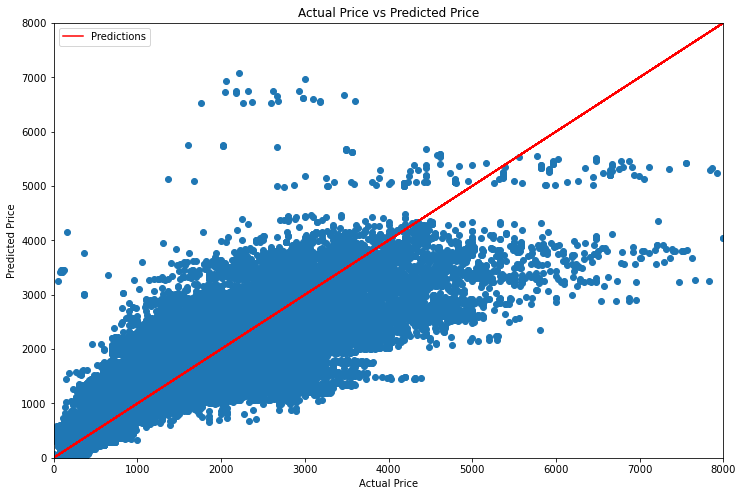

In [30]:
# Our predictions
fig  = plt.figure(figsize=(12,8))
fig.patch.set_facecolor('white')
x = np.arange(0, 10, 0.1)
plt.scatter(y_test,y_pred)

# Perfect predictions
line = plt.plot(y_test,y_test,'r')
plt.xlim([0, 8000])
plt.ylim([0, 8000])
# labels
plt.xlabel('Actual Price',)
plt.ylabel('Predicted Price')
plt.title('Actual Price vs Predicted Price')
plt.legend(line, ['Predictions']);



In [31]:
def predict(area_en ,category):
    # Create the pandas DataFrame 
    areas = df2.area_en.unique()
    categorys = df2.category.unique()
    result = "We don't support this area_en currently"
    if category in categorys:
        if area_en in areas :
            data = {'sold_date':dt.date.today(), 'category':category, 'area_en': area_en }
            new_data = pd.DataFrame(data=data ,index=[0])
            new_data['sold_date']=new_data['sold_date'].map(dt.datetime.toordinal)

            try:
                result = pipe.predict(new_data)[0]
            except ValueError:
                return "We don't support this area currently"

    return result
    

In [6]:
predict("Uhud","Residential")

NameError: name 'predict' is not defined

In [ ]:
#model dump(save)
with open("model","wb" ) as f:
    pickle.dump(pipe,f)